In [1]:
import numpy as np
import math 
import skimage as sk
import matplotlib.pyplot as plt
import cv2 as cv
from skimage.feature import hog
from skimage import io, color


image_name = "person.png"



image = cv.imread(f'{image_name}', cv.IMREAD_GRAYSCALE)
# Convert to numpy array
image = np.array(image) / 255.0


def resize_image(image, k = 1):
		# (128k, 64k) is the new size of the image
		new_size = (int(128 * k), int(64 * k))
		# Resize the image
		image = sk.transform.resize(image, new_size, anti_aliasing=True)
		return image
    
    
resized_image = resize_image(image, 1)

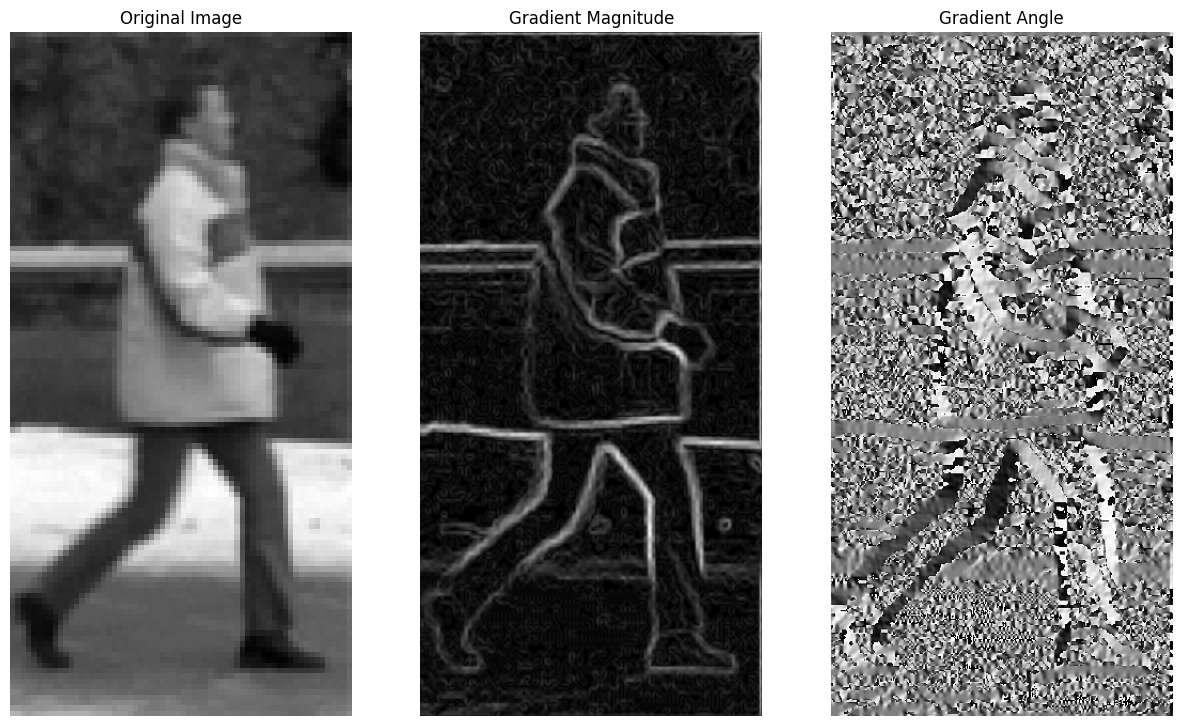

In [3]:
def convolve(image, kernel):
    '''
    Performs a convolution between the image and the kernel.
    '''
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height = kernel_height // 2
    pad_width = kernel_width // 2
    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), 'edge')
    # Initialize the output image
    output = np.zeros((image_height, image_width))
    # Convolution
    for i in range(image_height):
        for j in range(image_width):
            region = padded_image[i:i+kernel_height, j:j+kernel_width]
            output[i, j] = np.sum(region * kernel)

    return output


def prewitt_operator(grayscale_image):
    # Kernels Perwitt
    Gx = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
    Gy = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
    
    # Compute the gradient in the x and y directions
    grad_x = convolve(grayscale_image, Gx)
    grad_y = convolve(grayscale_image, Gy)
    
    # Compute the gradient magnitude
    magnitude = np.sqrt(grad_x**2 + grad_y**2)
    # Compute the gradient direction (angle)
    angle = np.arctan2(-grad_y, grad_x) * (180 / np.pi)
    # Ensure the angle is within 0 to 180 degrees
    angle[angle < 0] += 180
    angle = angle % 180
    
    return magnitude, angle

magnitude, angle = prewitt_operator(resized_image)


def generate_magnitude_and_angle_for_image(image_name, k=1):
		image = cv.imread(f'{image_name}', cv.IMREAD_GRAYSCALE)
		# Convert to numpy array
		image = np.array(image) / 255.0
		resized_image = resize_image(image, k)
		magnitude, angle = prewitt_operator(resized_image)
		return magnitude, angle
    
    
k = 5
magnitude, angle = generate_magnitude_and_angle_for_image(image_name, k)



# Create a figure to display the results
fig, axes = plt.subplots(1, 3, figsize=(15, 15))
ax = axes.ravel()
ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')
ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')
ax[2].imshow(angle, cmap='gray')
ax[2].set_title('Gradient Angle')
ax[2].axis('off')
plt.axis('off')
plt.show()

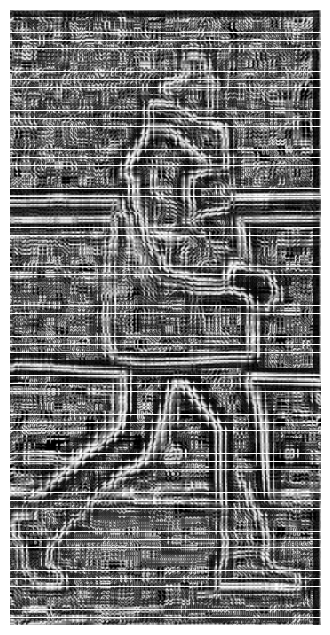

(3081, 9)

In [4]:
def get_block(area, row_step, col_step, block_size): return area[row_step : row_step + block_size, col_step : col_step + block_size]

def gen_blocks_stacks(magnitude, angle, block_size):
    
    HEIGHT, WIDTH = magnitude.shape
    STRIDE = block_size // 2
    M = int(HEIGHT / STRIDE) - 1
    N = int(WIDTH / STRIDE) - 1

    blocks_magnitude = np.zeros((M*N, block_size, block_size))
    blocks_angle = np.zeros((M*N, block_size, block_size))

    index = 0
    for i in range(M):
        for j in range(N):
            
            row_step = i * STRIDE
            col_step = j * STRIDE

            blocks_magnitude[index] = get_block(magnitude, row_step, col_step, block_size)
            blocks_angle[index] = get_block(angle, row_step, col_step, block_size)

            index += 1

            
    return blocks_magnitude, blocks_angle

block_size = 8 * 2
blocks_magnitude, blocks_angle = gen_blocks_stacks(magnitude, angle, block_size)


Y = int((int(128)*k / (block_size // 2) ) -1)
X = int((int(64)*k / (block_size // 2) ) -1)

fig, axes = plt.subplots(Y,X, figsize=(4, 8))
ax = axes.ravel()

for i in range(Y*X):
    ax[i].imshow(blocks_magnitude[i], cmap='gray')
    ax[i].axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0)
plt.show()


def build_histograms(m_bstack, a_bstack, n_bins=9):
    MN, block_size, _ = m_bstack.shape
    histograms = np.zeros((MN, n_bins))
    step_size = 180 / n_bins

    for i in range(MN):
        for j in range(block_size):
            for k in range(block_size):
                angle = a_bstack[i][j][k]
                magnitude = m_bstack[i][j][k]

                bin_ = math.floor(((angle / step_size) - 1/2))
                bin_center = step_size * ((bin_ + 1) + 1/2)
                bin_value = magnitude * ((bin_center - angle) / step_size)

                histograms[i][bin_] += bin_value

    return histograms

def normalize_histograms(histograms):
    epsilon = 0.000000000000000001
    return histograms / np.sqrt(np.sum(histograms**2, axis=1) + epsilon).reshape(-1, 1)


n_bins = 9
histograms = build_histograms(blocks_magnitude, blocks_angle, n_bins)
normalized_histograms = normalize_histograms(histograms)

normalized_histograms.shape


def build_histograms(m_bstack, a_bstack, n_bins=9):
    MN, block_size, _ = m_bstack.shape
    histograms = np.zeros((MN, n_bins))
    step_size = 180 / n_bins

    for i in range(MN):
        for j in range(block_size):
            for k in range(block_size):
                angle = a_bstack[i][j][k]
                magnitude = m_bstack[i][j][k]

                bin_ = math.floor(((angle / step_size) - 1/2))
                bin_center = step_size * ((bin_ + 1) + 1/2)
                bin_value = magnitude * ((bin_center - angle) / step_size)

                histograms[i][bin_] += bin_value

    return histograms

def normalize_histograms(histograms):
    epsilon = 0.000000000000000001
    return histograms / np.sqrt(np.sum(histograms**2, axis=1) + epsilon).reshape(-1, 1)


n_bins = 9
histograms = build_histograms(blocks_magnitude, blocks_angle, n_bins)
normalized_histograms = normalize_histograms(histograms)

normalized_histograms.shape

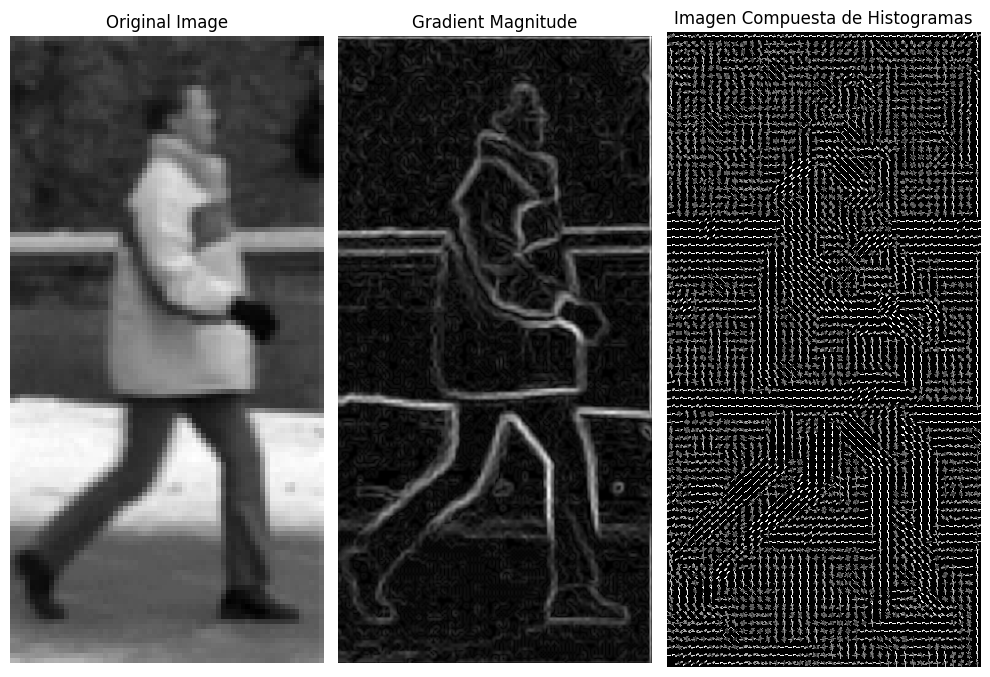

In [6]:
def draw_line(img, center, angle, length, intensity):
    """Dibuja líneas desde el centro en ambas direcciones según el ángulo."""
    for sign in [-1, 1]:  # Dibuja en ambas direcciones
        end_x = center[0] + sign * length * np.cos(angle)
        end_y = center[1] + sign * length * np.sin(angle)
        
        # Asegurarse de que los índices estén dentro de los límites
        x, y = np.linspace(center[0], end_x, num=100), np.linspace(center[1], end_y, num=100)
        ix, iy = np.clip(x, 0, img.shape[1]-1).astype(int), np.clip(y, 0, img.shape[0]-1).astype(int)
        img[iy, ix] = intensity

def draw_histogram_block(histogram, max_global_value, block_size=16, max_length=7):
    """Dibuja el histograma en un bloque con líneas que representan los valores, normalizado globalmente."""
    img = np.zeros((block_size, block_size))
    center = (block_size // 2, block_size // 2)
    
    for i, value in enumerate(histogram):
        # Calcula el ángulo y la intensidad de la línea, usando la normalización global
        angle = (np.pi * i / (len(histogram) - 1)) + (np.pi / 2)  # Distribuye los ángulos sobre 180 grados
        intensity = value / max_global_value  # Normaliza la intensidad de la línea globalmente
        length = max_length * intensity  # Ajusta la longitud de la línea según la intensidad
        
        draw_line(img, center, angle, length, intensity)
    
    return img

def create_composite_image(histograms, block_size=8, max_global_value=None):
    # Si max_global_value no se proporciona, calcularlo a partir de todos los histogramas
    if max_global_value is None:
        max_global_value = histograms.max()

    # Dimensiones de la imagen compuesta
    num_blocks_y, num_blocks_x, _ = Y, X, 9
    comp_height = num_blocks_y * block_size
    comp_width = num_blocks_x * block_size
    
    # Crear imagen compuesta inicializada en negro
    composite_image = np.zeros((comp_height, comp_width))

    line = 0
    
    # Iterar sobre cada bloque para dibujarlo en la posición correcta
    for i in range(num_blocks_x * num_blocks_y):
        # Generar la imagen del bloque actual
        block_image = draw_histogram_block(histograms[i], max_global_value, block_size)
        # Calcular la posición superior izquierda donde colocar el bloque
        top_left_y = line * block_size
        top_left_x = i%num_blocks_x * block_size

        if i !=0 and i%num_blocks_x == 0:
            line += 1
        # Colocar el bloque en la imagen compuesta
        composite_image[top_left_y:top_left_y + block_size, top_left_x:top_left_x + block_size] = block_image
    
    return composite_image

import matplotlib.pyplot as plt

composite_image = create_composite_image(normalized_histograms)
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].imshow(resized_image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(magnitude, cmap='gray')
ax[1].set_title('Gradient Magnitude')
ax[1].axis('off')


ax[2].imshow(composite_image, cmap='gray', interpolation='nearest')
ax[2].set_title("Imagen Compuesta de Histogramas")
ax[2].axis('off')

plt.tight_layout()
plt.show()

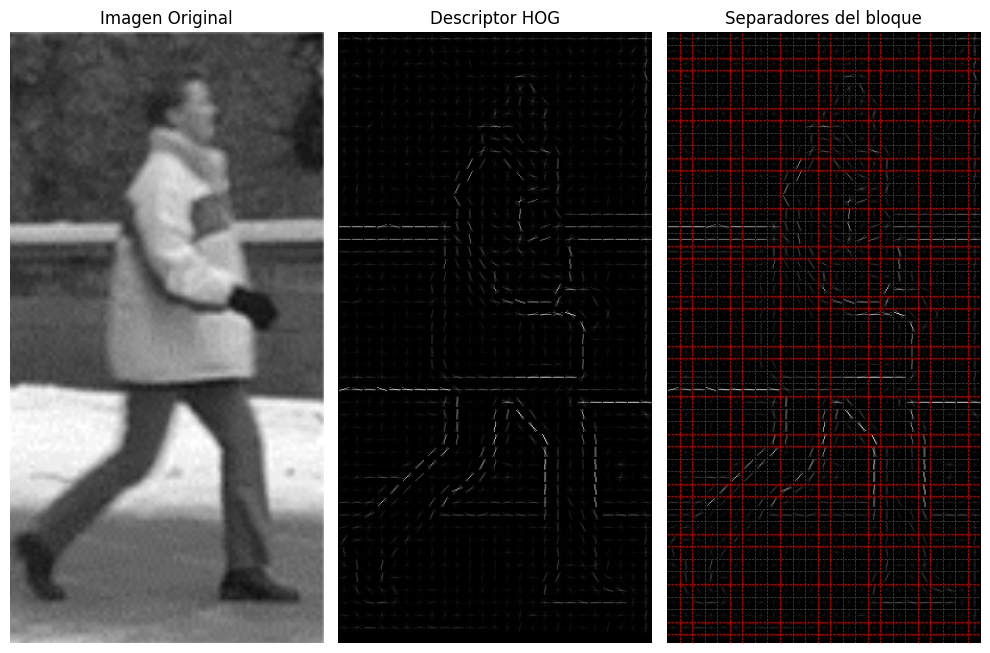

In [7]:
# Procesado de imagen
image_rgb = io.imread('person.png')

if image_rgb.shape[2] == 4:
    image_rgb = image_rgb[:, :, :3]

image_gray = color.rgb2gray(image_rgb)
secciones = 25

alto, ancho = 585, 300
tamaño_bloque_horizontal = ancho // secciones
bloques_verticales = int(np.ceil(alto / tamaño_bloque_horizontal))
tamaño_bloque = (tamaño_bloque_horizontal, tamaño_bloque_horizontal)

# Calcular el descriptor HOG con bloques cuadrados
fd, hogI = hog(image_gray, orientations=9, pixels_per_cell=tamaño_bloque, cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys')

fig, axes = plt.subplots(1, 3, figsize=(10, 10))
axes[0].imshow(image_rgb)
axes[0].set_title('Imagen Original')
axes[0].axis('off')

axes[1].imshow(hogI, cmap='gray')
axes[1].set_title('Descriptor HOG')
axes[1].axis('off')

axes[2].imshow(hogI, cmap='gray')
axes[2].set_title('Separadores del bloque')
axes[2].axis('off')

for i in range(1, secciones):
    axes[2].axvline(x=i*tamaño_bloque_horizontal, color='r', linestyle='--', linewidth=0.5)
for i in range(1, bloques_verticales):
    axes[2].axhline(y=i*tamaño_bloque_horizontal, color='r', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()

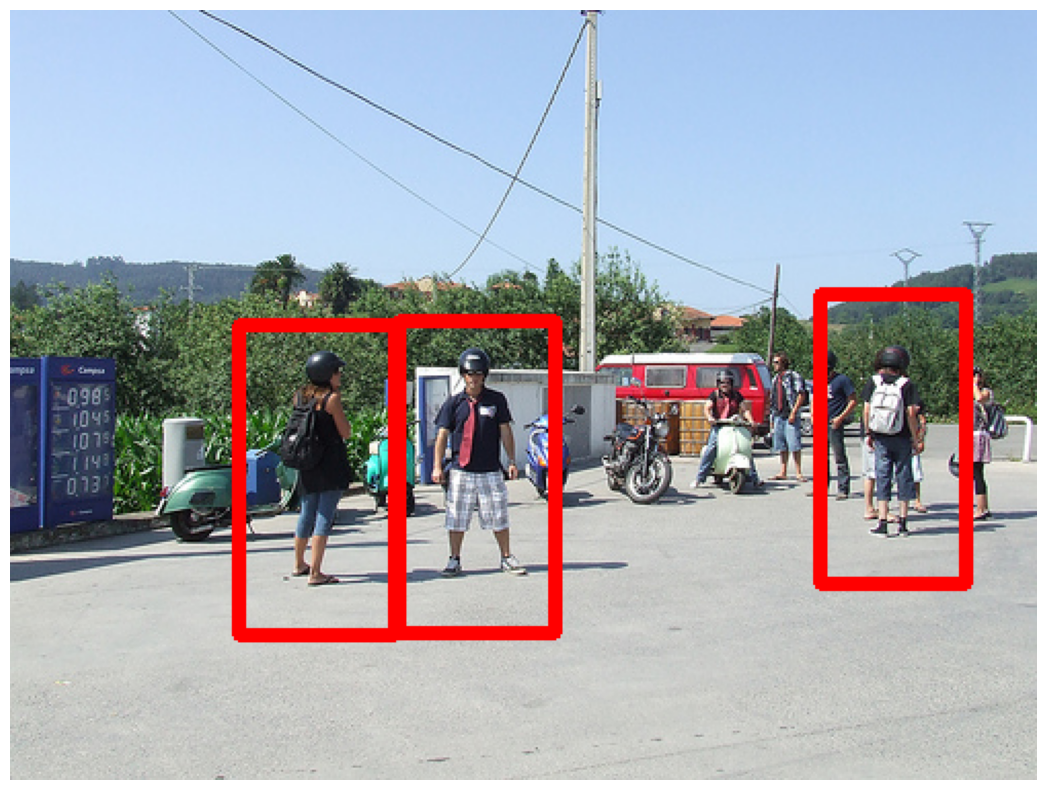

In [9]:
def detect_people(image_path):
    image = cv.imread(image_path)

    # Crear el detector HOG pre-entrenado para la detección de personas
    hog_detector = cv.HOGDescriptor()
    hog_detector.setSVMDetector(cv.HOGDescriptor_getDefaultPeopleDetector())

    locations, confidence = hog_detector.detectMultiScale(image)

    # Dibujar los rectángulos alrededor de las personas detectadas
    for (x, y, w, h) in locations:
        cv.rectangle(image, (x, y), (x + w, y + h), (0, 0, 255), 5)

    image_rgb = cv.cvtColor(image, cv.COLOR_BGR2RGB)

    plt.figure(figsize=(20, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()
    
    
image_path = '57.jpeg'
detect_people(image_path)